In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm, lognorm, ncx2
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from src.Utility import Utility, MeasurementType
from src.KalmanFilterCorrFTE import HestonKalmanFilterFTE
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

In [3]:
df = pd.read_parquet(r"data/oxford_data.parquet")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.loc[pd.to_datetime('2014-01-01'):pd.to_datetime('2018-06-01')]
df['return'] = np.log(df['close_price']).diff()

In [25]:
# Get descriptive statistics including Jarque-Bera
sm.stats.DescrStatsW(df['return'])

In [22]:
.describe()

count    1111.000000
mean        0.000360
std         0.007979
min        -0.041636
25%        -0.002826
50%         0.000413
75%         0.004452
max         0.038012
Name: return, dtype: float64

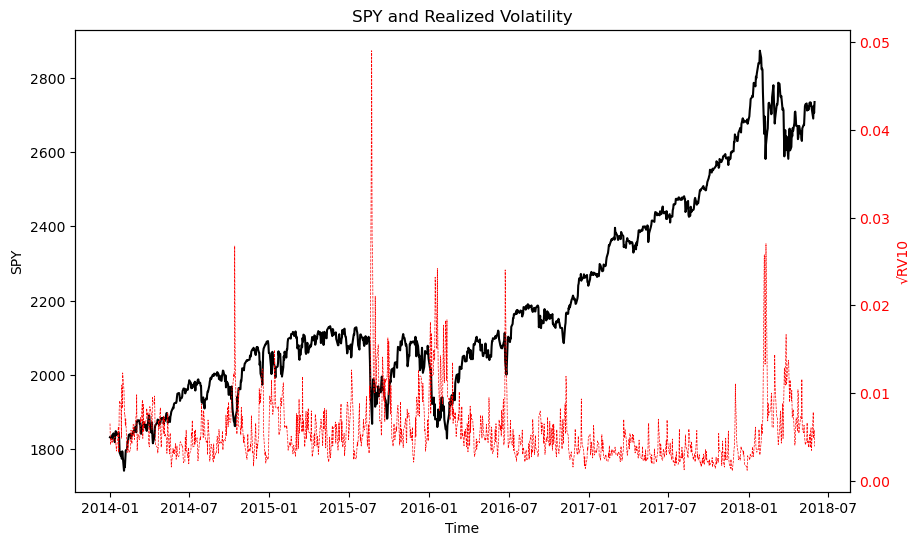

In [18]:
# Assuming df is your DataFrame and already has datetime index
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot close price on the left y-axis
color = 'black'
ax1.set_xlabel('Time')
ax1.set_ylabel('SPY', color=color)
ax1.plot(df.index, df['close_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for RV
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('√RV10', color=color)
ax2.plot(df.index, np.sqrt(df['rv10']), color=color, linestyle='dashed', linewidth=0.5)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.title('SPY and Realized Volatility')
plt.show()

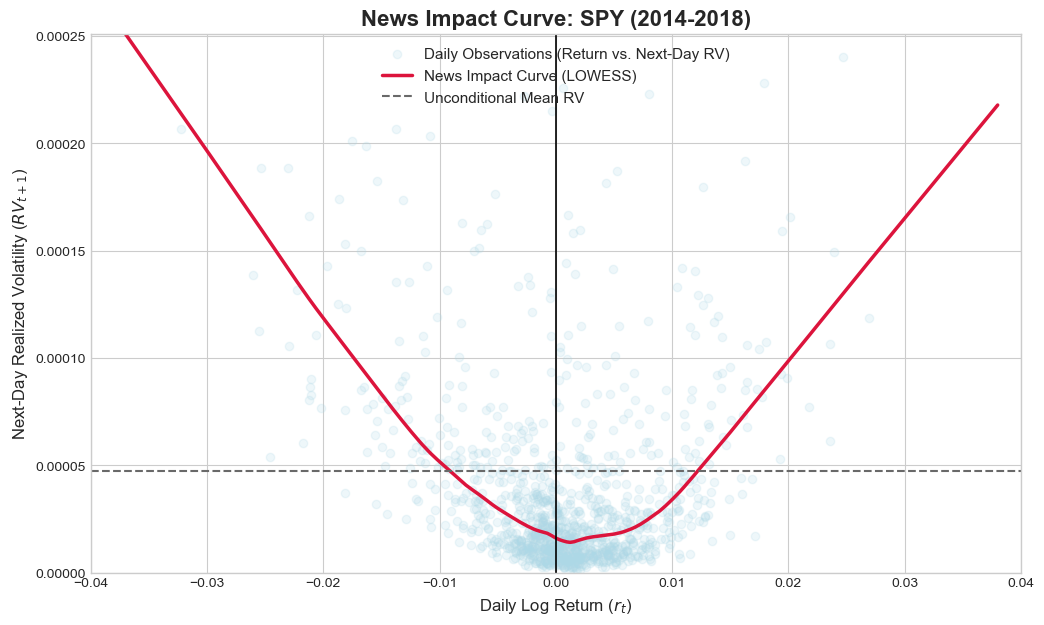

In [21]:
df['next_day_rv10'] = df['rv10'].shift(-1)

df_nic = df.dropna()

# Define our x (independent) and y (dependent) variables
x_returns = df_nic['return']
y_next_vol = df_nic['rv10']

# --- 3. Perform LOWESS Smoothing ---
# LOWESS fits a smooth curve to the data non-parametrically.
# The 'frac' parameter controls the amount of smoothing (0.3 is a good start).
lowess_fit = sm.nonparametric.lowess(endog=y_next_vol, exog=x_returns, frac=0.3)

# Extract the smoothed x and y values
x_smooth = lowess_fit[:, 0]
y_smooth = lowess_fit[:, 1]

# --- 4. Generate the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the raw observations as a scatter plot
ax.scatter(x_returns, y_next_vol, alpha=0.2, color='lightblue', label='Daily Observations (Return vs. Next-Day RV)')

# Plot the smoothed News Impact Curve
ax.plot(x_smooth, y_smooth, color='crimson', linewidth=2.5, label='News Impact Curve (LOWESS)')

# Add reference lines for clarity
ax.axhline(y=y_next_vol.mean(), color='dimgray', linestyle='--', linewidth=1.5, label=f'Unconditional Mean RV')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.2)

# Add titles and labels for a publication-quality figure
ax.set_title('News Impact Curve: SPY (2014-2018)', fontsize=16, weight='bold')
ax.set_xlabel('Daily Log Return ($r_t$)', fontsize=12)
ax.set_ylabel('Next-Day Realized Volatility ($RV_{t+1}$)', fontsize=12)
ax.legend(loc='upper center', fontsize=11)

# Set axis limits to focus on the area of interest
ax.set_xlim(-0.04, 0.04)
ax.set_ylim(0, df_nic['next_day_rv10'].quantile(0.98)) # Zoom in by excluding extreme outliers

plt.show()


In [74]:
r_t   = np.diff(np.log(df['close_price'].values))            # length T-1
dv_t  = df['rv10'].values[1:]                # length T-1

np.corrcoef(r_t, dv_t)

array([[ 1.        , -0.21849234],
       [-0.21849234,  1.        ]])

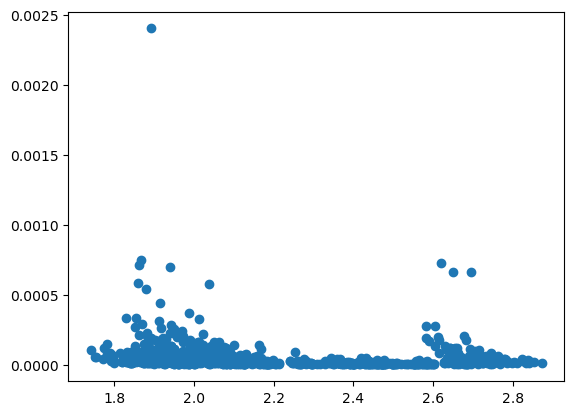

In [78]:
plt.scatter(df['close_price']/1000, df['rv10'])

In [4]:
daily_returns = df['return'].iloc[1:]
daily_RV = df['rv10'].iloc[1:]

burnin = 252
dt = 1  # Daily

split_index = round(df.shape[0] * 0.82)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

## RV-QLKF

In [80]:
hkf_both_corr = HestonKalmanFilterFTE(measurement_type=MeasurementType.BOTH, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.01, 0.002, 0.001, 0.001, 0.001, -0.25]) # kappa, theta, xi, mu, sigma, rho
# 0.0194974349, 0.00108918014, 0.00817043974, 0.0000760274950, 0.00000100000000, -0.499673084
fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterFTE(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.75435D+03    |proj g|=  6.66260D+05

At iterate    1    f= -6.94708D+03    |proj g|=  3.85021D+04

At iterate    2    f= -7.00343D+03    |proj g|=  1.23998D+00

At iterate    3    f= -7.04194D+03    |proj g|=  2.38662D+03

At iterate    4    f= -7.04626D+03    |proj g|=  3.65140D+04

At iterate    5    f= -7.17087D+03    |proj g|=  9.89559D+04
  ys=-2.504E+02  -gs= 1.392E+02 BFGS update SKIPPED

At iterate    6    f= -7.21793D+03    |proj g|=  1.23990D+00

At iterate    7    f= -7.24488D+03    |proj g|=  1.23988D+00

At iterate    8    f= -7.31114D+03    |proj g|=  2.00000D+00

At iterate    9    f= -7.40280D+03    |proj g|=  2.00000D+00

At iterate   10    f= -7.44182D+03    |proj g|=  7.40263D-01

At iterate   11    f= -7.45365D+03    |proj g|=  7.40258D-01

At iterate   12    f= -7.46425D+03  

## QLKF

In [81]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterFTE(measurement_type=MeasurementType.RETURNS, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.25]) # kappa, theta, xi, mu, rho
# initial_params_returns_corr = np.array([0.02, 0.002, 0.001, 0.001, -0.5]) # kappa, theta, xi, mu, sigma, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterFTE(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16539D+03    |proj g|=  8.85684D+03

At iterate    1    f= -2.23219D+03    |proj g|=  8.82910D+03

At iterate    2    f= -2.23331D+03    |proj g|=  8.74817D+02

At iterate    3    f= -2.32997D+03    |proj g|=  2.22544D+06

At iterate    4    f= -2.33068D+03    |proj g|=  8.92880D+04
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    5    f= -2.33305D+03    |proj g|=  1.02380D+04

At iterate    6    f= -2.33311D+03    |proj g|=  1.20482D+04

At iterate    7    f= -2.33320D+03    |proj g|=  1.11950D+04

At iterate    8    f= -2.33339D+03    |proj g|=  1.00446D+04

At iterate    9    f= -2.33364D+03    |proj g|=  7.40000D-01

At iterate   10    f= -2.33364D+03    |proj g|=  3.41540D+02

At iterate   11    f= -2.33364D+03    |proj g|=  4.11703D+02

At iterate   12 

## PF 

In [7]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (0.02, 0.5),      # mu
    (1, 9),           # kappa
    (0.02, 0.2),     # theta
    (0.01, 0.91),       # xi
    (-0.5, 0),        # rho
    daily_RV[0]       # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1.0074084240508554
resampling since: 39.08704933579562
resampling since: 5764.892144292073
resampling since: 5900.766973037029
resampling since: 4880.513112682112
resampling since: 6833.64999530652
resampling since: 3528.5036421866043
resampling since: 4919.884056084667
resampling since: 5821.064456236975
resampling since: 5838.210059340229
resampling since: 6966.016156400044
resampling since: 5854.152813965746
resampling since: 6092.678183264485
resampling since: 6104.100400280443
resampling since: 6896.972696289687
resampling since: 5184.769158981401
resampling since: 5936.070532924971
resampling since: 5544.070036817598
resampling since: 6418.93887498167
resampling since: 6428.1807905664045
resampling since: 6450.509067308817
resampling since: 5903.766242591499
resampling since: 6918.543589093994
resampling since: 2070.852810705876
resampling since: 6914.118192285794
resampling since: 6759.620887709639
resampling since: 6667.629455433762
resampling since: 4789.4758

In [8]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, daily_RV[0]], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 4423.657819752246
resampling since: 6860.719072512821
resampling since: 5569.896558329626
resampling since: 4525.272322969125
resampling since: 4587.280985967024
resampling since: 6854.556575992144
resampling since: 6383.505034502588
resampling since: 6324.525871777574
resampling since: 5364.628922351065
resampling since: 6412.741865046063
resampling since: 6489.444642937228
resampling since: 6880.696104358275
resampling since: 6172.5020930158735
resampling since: 6345.491805590079
resampling since: 5486.360208859009
resampling since: 5326.405591957717
resampling since: 6447.511067893772
resampling since: 6095.894256664267
resampling since: 6331.721849580281
resampling since: 6693.521425920265
resampling since: 5623.291620988009
resampling since: 1788.8176987913964
resampling since: 6044.310702092103
resampling since: 5347.92988162554
resampling since: 6496.914933459022
resampling since: 6496.464097491591
resampling since: 6162.092211950205
resampling since: 6933.2778

In [9]:
V_pf_train_daily = V_pf_train / 500
V_pf_test_daily = V_pf_test / 500

## Realized GARCH

In [10]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

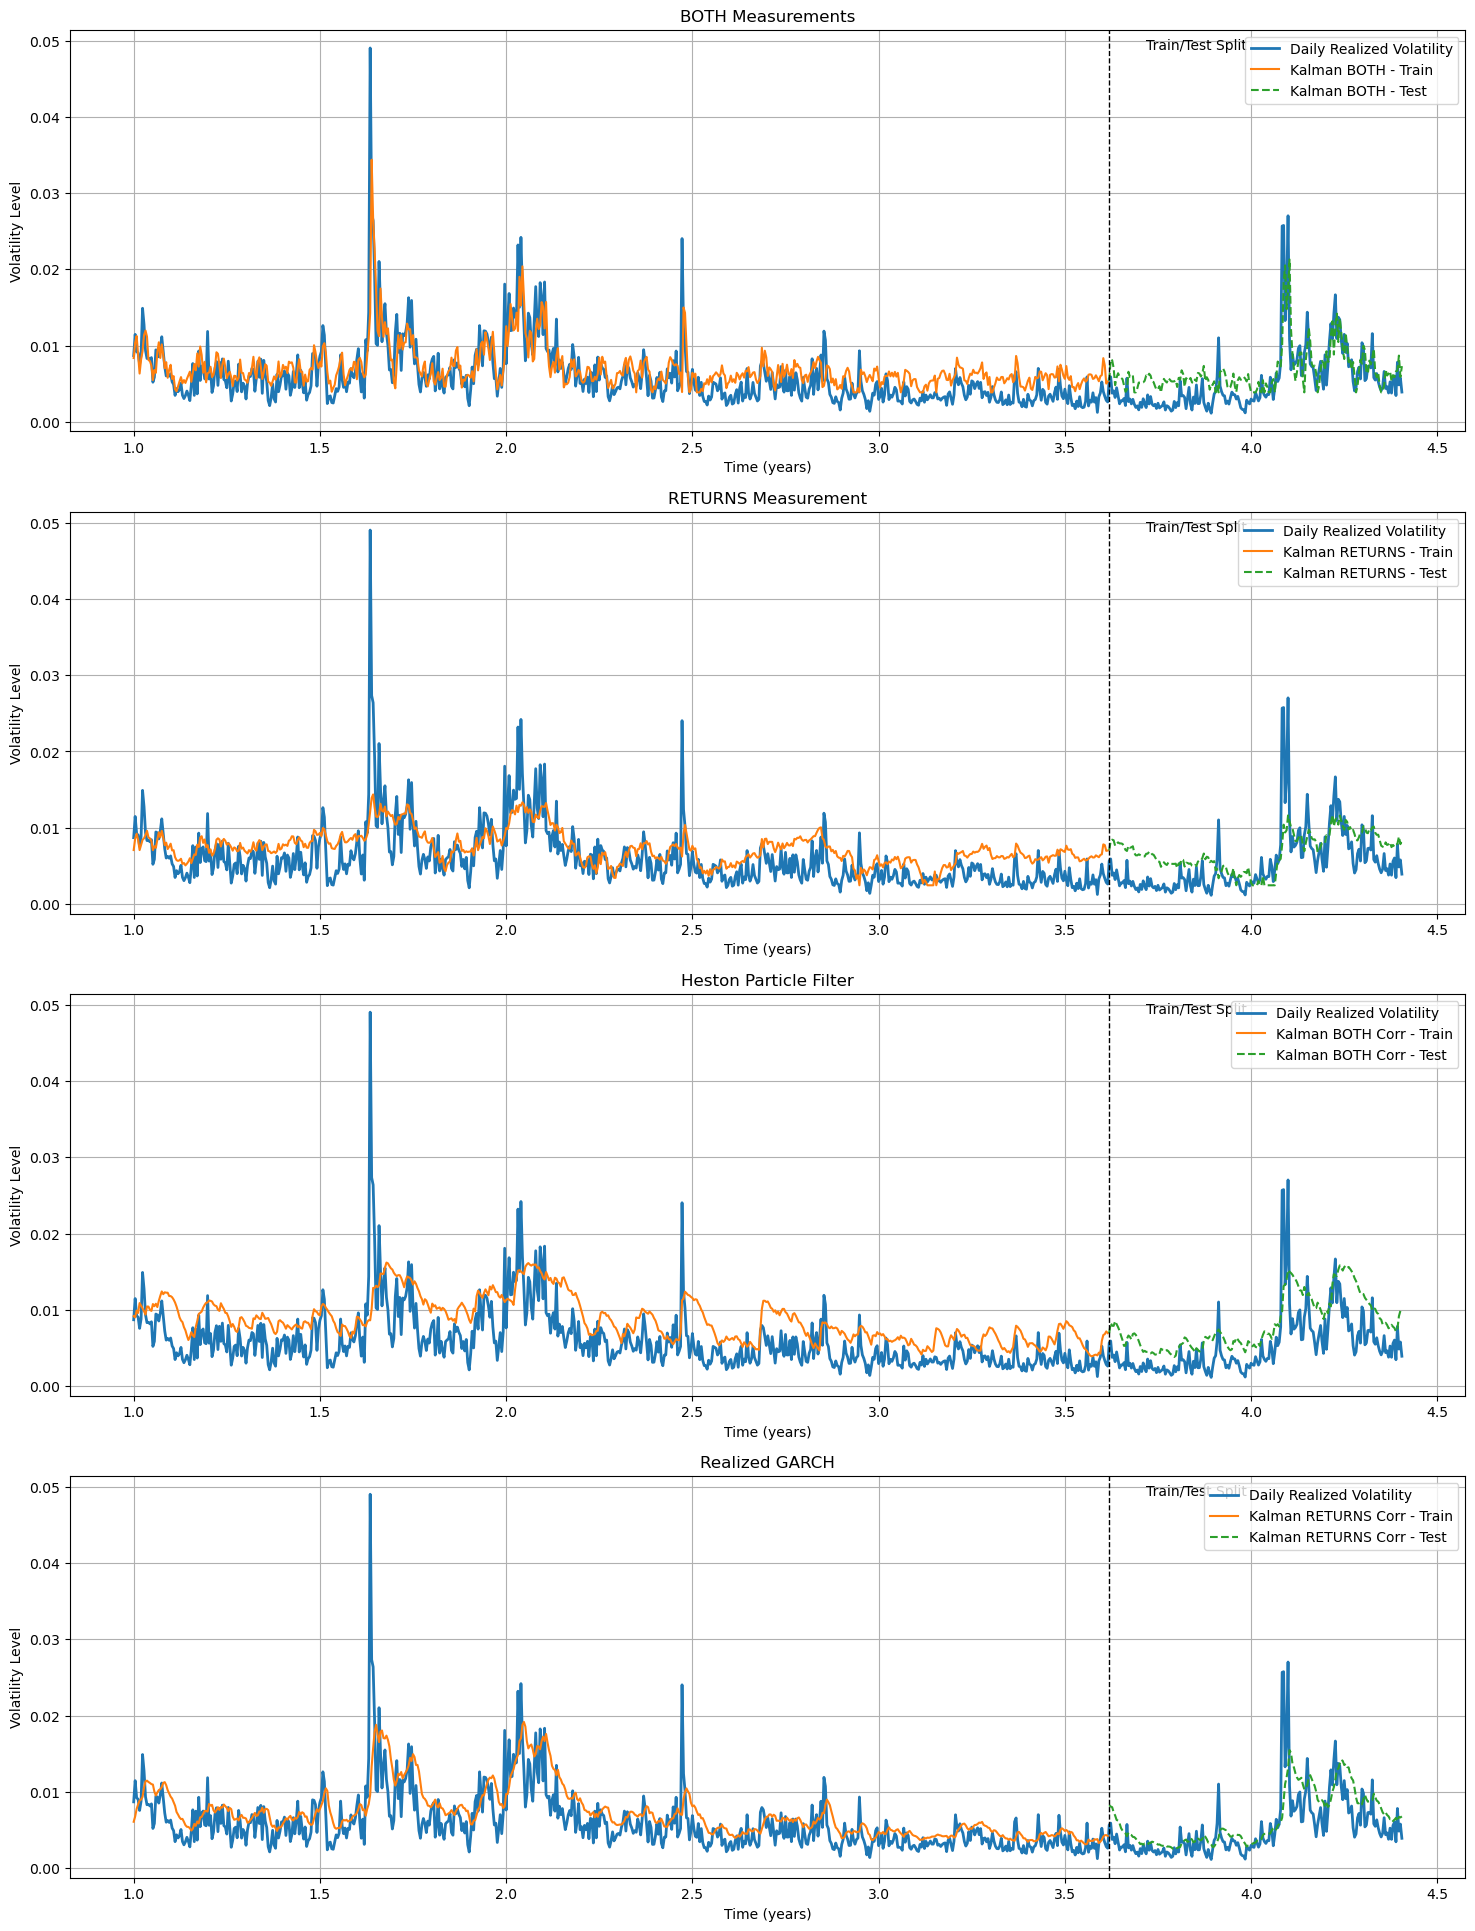

In [82]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item].clip(1.5e-5, None), train_result_returns_corr[v_item].clip(6e-6, None), V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item].clip(1.5e-5, None), test_result_returns_corr[v_item].clip(6e-6, None), V_pf_test_daily, predicted_vol]

burnin = 252
time_daily = np.arange(len(daily_returns)) / 252
n_filters = len(train_all)
fig, axes = plt.subplots(n_filters, 1, figsize=(18, 6 * n_filters))

for i, ax in enumerate(axes):
    # Slice data
    filt_train = train_all[i][burnin:]
    true_train = daily_RV[burnin:split_index]
    filt_test = test_all[i]
    true_test = daily_RV[split_index:]

    # Sanity checks
    assert len(filt_train) == len(true_train), f"In-sample length mismatch for {titles_all[i]}"
    assert len(filt_test) == len(true_test), f"Out-of-sample length mismatch for {titles_all[i]}"

    # Plot true and predicted volatility
    ax.plot(time_daily[burnin:], np.sqrt(daily_RV[burnin:]), label="Daily Realized Volatility", lw=2)
    ax.plot(time_daily[burnin:split_index], np.sqrt(filt_train), label=f"{labels_all[i]} - Train", lw=1.5)
    ax.plot(time_daily[split_index:], np.sqrt(filt_test), label=f"{labels_all[i]} - Test", lw=1.5, linestyle="--")

    # Mark the train/test split
    ax.axvline(time_daily[split_index], color='black', linestyle='--', lw=1)
    ax.text(time_daily[split_index] + 0.1, ax.get_ylim()[1]*0.95, 'Train/Test Split', color='black')

    # === Add vertical lines for negative predicted variances ===
    # For train
    neg_train_indices = np.where(np.array(filt_train) < 0)[0]
    for idx in neg_train_indices:
        ax.axvline(time_daily[burnin + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # For test
    neg_test_indices = np.where(np.array(filt_test) < 0)[0]
    for idx in neg_test_indices:
        ax.axvline(time_daily[split_index + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # Final plot styling
    ax.set_title(f"{titles_all[i]}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Volatility Level")
    ax.legend(loc="upper right")
    ax.grid(True)

In [83]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    # eps = np.finfo(float).eps
    # ratio = y / (h + eps)
    ratio = y / h
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances = daily_RV[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all)):
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    pred_vol = np.sqrt(pred_var)

    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.003059, QLIKE: 0.503309
QLKF               RMSE: 0.003590, QLIKE: 0.645514
PF                 RMSE: 0.004071, QLIKE: 0.589845
Realized GARCH     RMSE: 0.003289, QLIKE: 0.405672


In [89]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 170.76model/s]


In [90]:
mcs_mse_results_90

,pvalues,status
models,,
3,0.0585,excluded
2,0.0968,excluded
4,0.5791,included
1,1.0000,included


In [91]:
mcs_qlike_results_90

,pvalues,status
models,,
2,0.0462,excluded
3,0.0640,excluded
1,0.3599,included
4,1.0000,included


In [92]:
mcs_mse_results_75

,pvalues,status
models,,
3,0.0615,excluded
2,0.1073,excluded
4,0.5760,included
1,1.0000,included


In [93]:
mcs_qlike_results_75

,pvalues,status
models,,
2,0.0438,excluded
3,0.0619,excluded
1,0.3617,included
4,1.0000,included


# Distribution of returns

In [26]:
df['return']

Time
2014-01-02         NaN
2014-01-03   -0.000344
2014-01-06   -0.002646
2014-01-07    0.006113
2014-01-08   -0.000278
                ...   
2018-05-24   -0.002390
2018-05-28   -0.011562
2018-05-29    0.012634
2018-05-30   -0.006922
2018-05-31    0.010677
Name: return, Length: 1112, dtype: float64

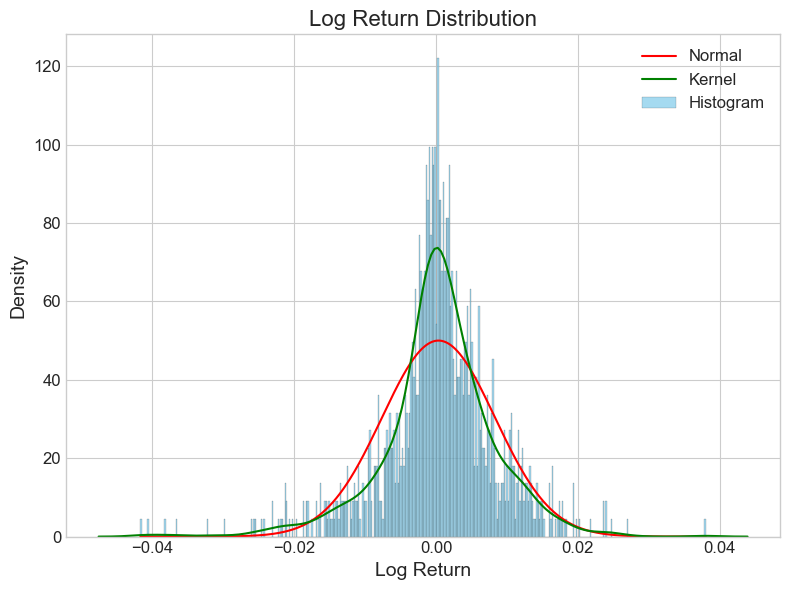

In [27]:
# Prepare data
log_ret = df['return'].dropna()

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(log_ret, kde=False, stat='density', bins=400, color='skyblue', label='Histogram')

# Normal fit
mu, std = norm.fit(log_ret)
x_vals = np.linspace(log_ret.min(), log_ret.max(), 500)
plt.plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Kernel Density Estimate
sns.kdeplot(log_ret, color='green', label='Kernel')

# Labels and formatting
plt.title('Log Return Distribution', fontsize=16)
plt.xlabel('Log Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Distribution of RV

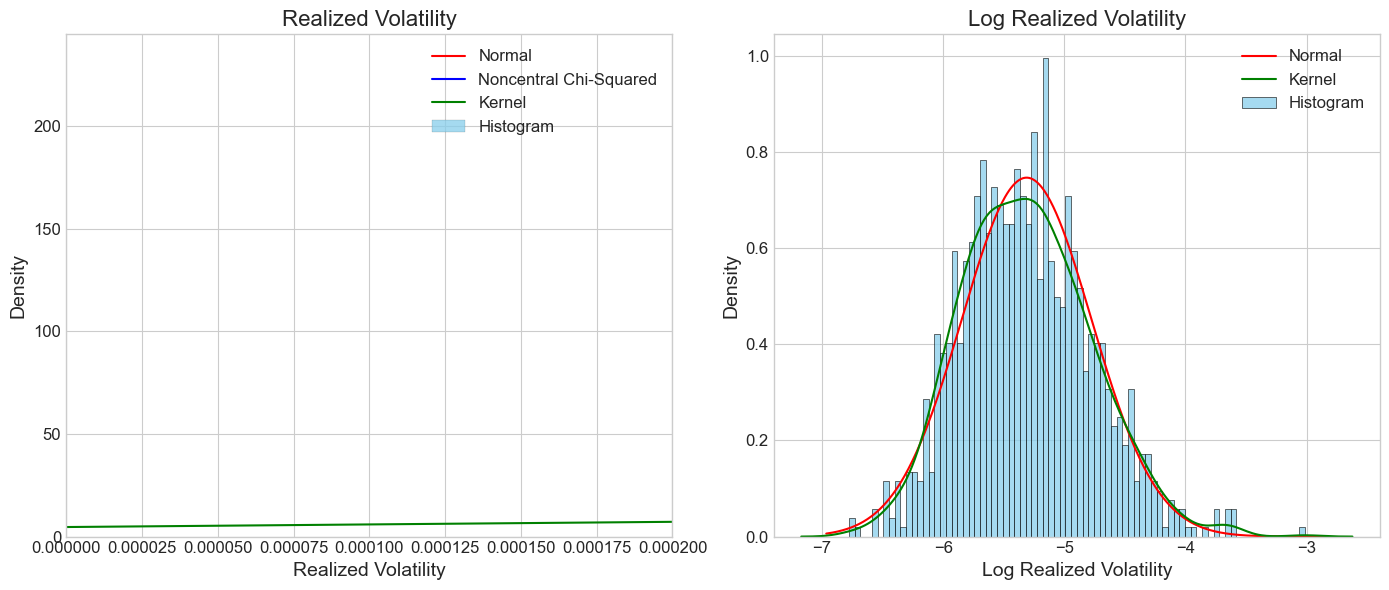

In [28]:
# Prepare data
rv = np.sqrt(df['rv10']).dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Realized volatility histogram and density curves
sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the log normal distribution
# shape_logn, loc_logn, scale_logn = lognorm.fit(rv, floc=0)  # Usually loc is set to 0
# ax[0].plot(x_vals, lognorm.pdf(x_vals, shape_logn, loc=loc_logn, scale=scale_logn), 'r', label='Lognormal')

mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Fit the noncentral chi-squared distribution with loc fixed at 0
df_ncx2, nc_val, loc_val, scale_val = ncx2.fit(rv, floc=0)
ax[0].plot(x_vals, ncx2.pdf(x_vals, df_ncx2, nc_val, loc=loc_val, scale=scale_val), 'b', label='Noncentral Chi-Squared')

# Add kernel density estimate
sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized Volatility', fontsize=16)
ax[0].set_xlabel('Realized Volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0002)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log realized volatility histogram and normal density
sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log Realized Volatility', fontsize=16)
ax[1].set_xlabel('Log Realized Volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


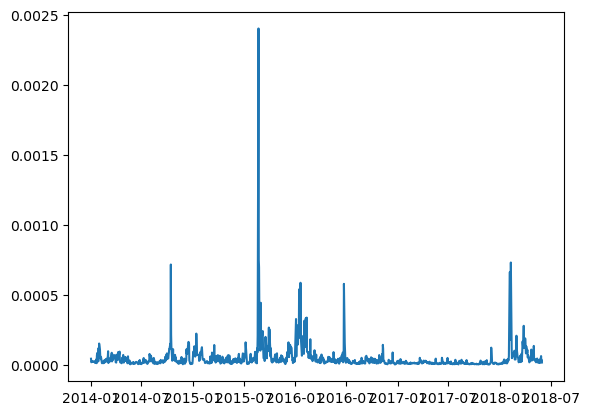

In [17]:
plt.plot(rv)

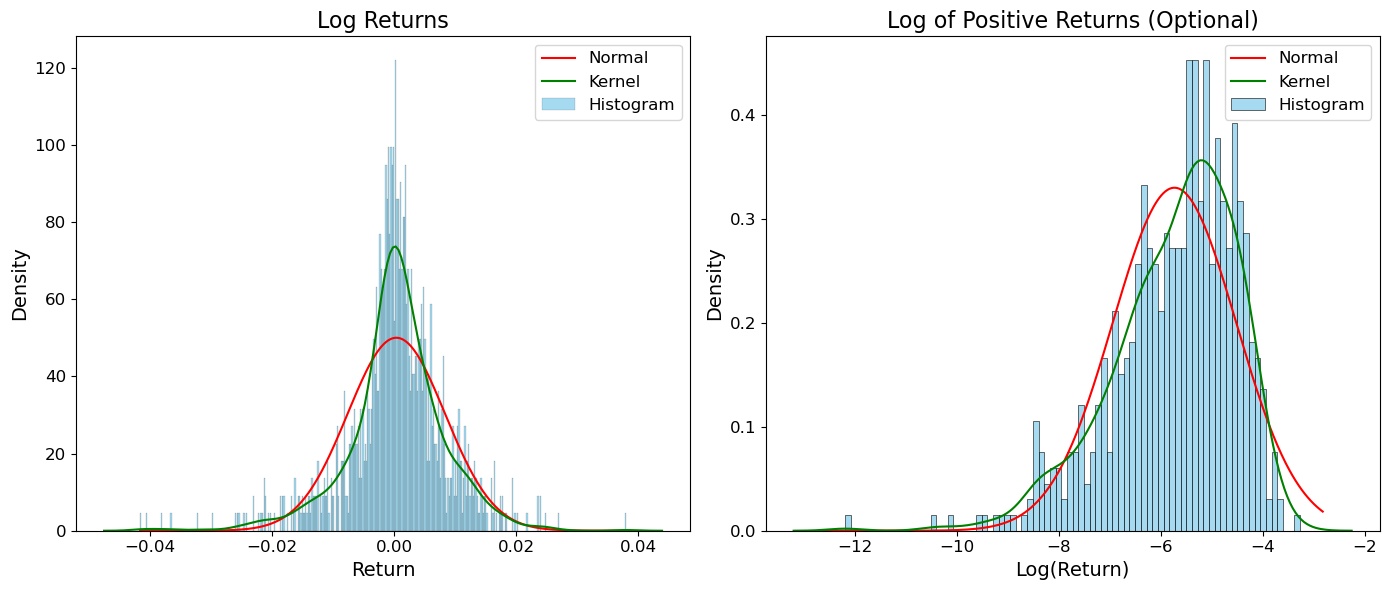

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Prepare data
rtn = np.log(df['close_price']).diff().dropna()
log_rtn = np.log(rtn[rtn > 0])  # optional, if you want to still look at log of positive returns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Return histogram and density curves
sns.histplot(rtn, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rtn.min(), rtn.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the normal distribution
mu_rtn, std_rtn = norm.fit(rtn)
ax[0].plot(x_vals, norm.pdf(x_vals, mu_rtn, std_rtn), 'r', label='Normal')

# Add kernel density estimate
sns.kdeplot(rtn, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Log Returns', fontsize=16)
ax[0].set_xlabel('Return', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log of positive returns (optional, for exploration)
sns.histplot(log_rtn, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rtn)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rtn, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log of Positive Returns (Optional)', fontsize=16)
ax[1].set_xlabel('Log(Return)', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Autocorrelation

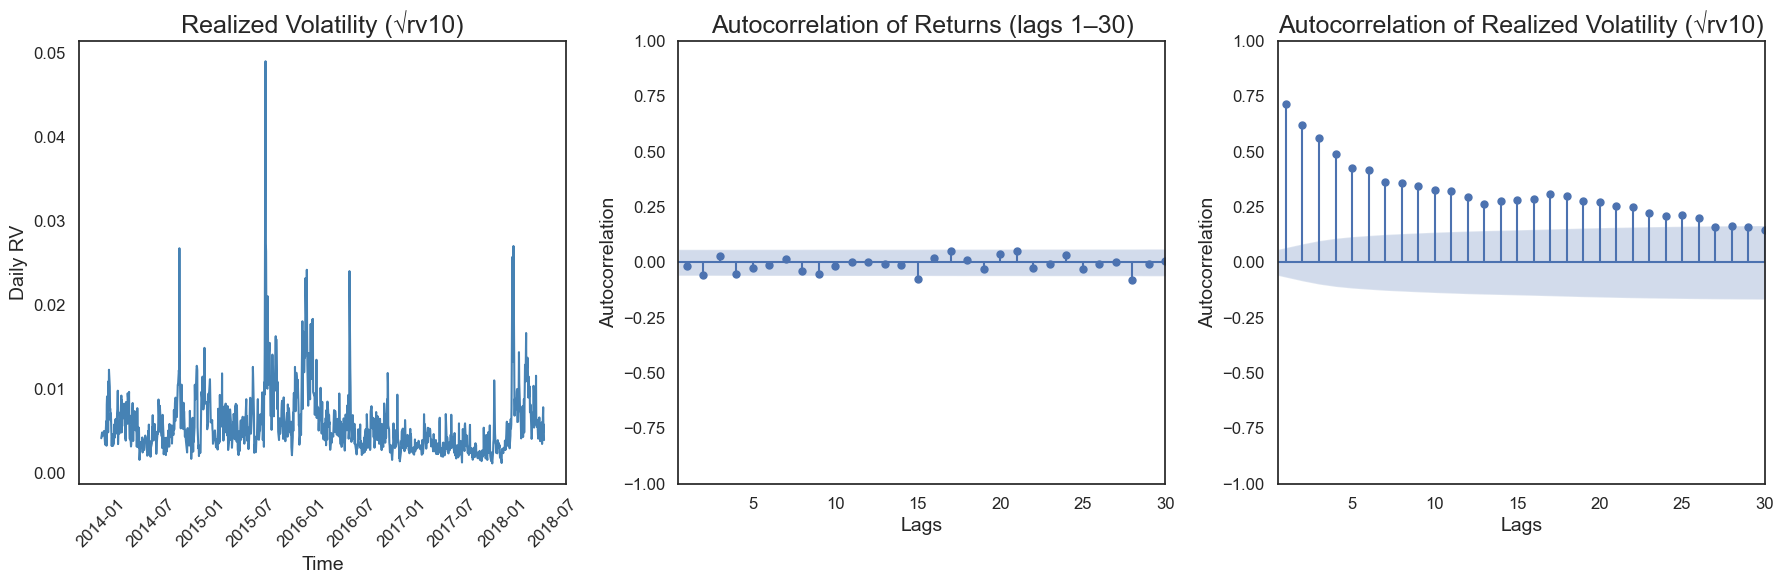

In [19]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=18)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=18)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=18)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()